# Spectral Normalization Implementation

## Required Libraries

First of all, we start by importing our libraries.

In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.optim.optimizer import Optimizer, required
from torch.autograd import Variable
import torch.nn.functional as F
from torch import Tensor
from torch.nn import Parameter
torch.manual_seed(0) # Set for testing purposes, please do not change!


def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

## Spectral Normalization

We will apply the following algorithm to create a Spectral Normalization Module.

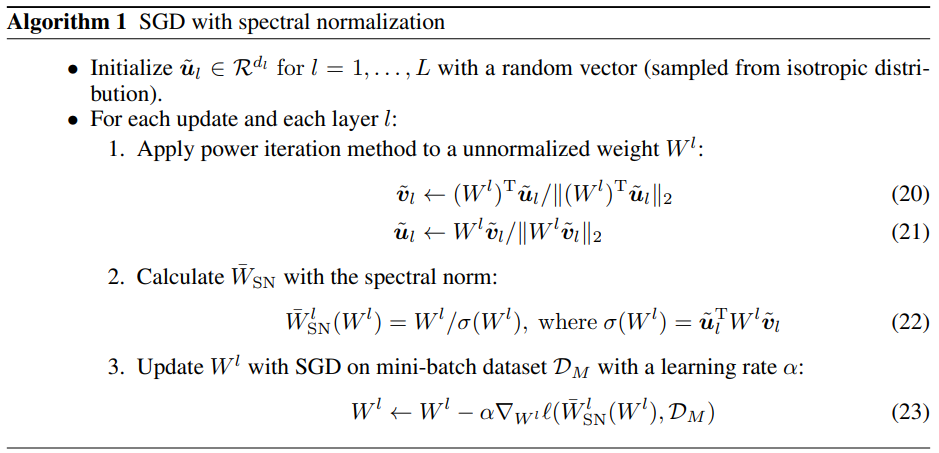

In [2]:
# We will create our Spectral Normalization class and inherit from torch.nn.module

class SpectralNorm(nn.Module):
    
  def __init__(self, module):
    super(SpectralNorm, self).__init__()                                        # Caling our parent class contructor for parameters initialization.
    self.module = module
    self.epsilon = 1e-12
    w = getattr(self.module, 'weight')
    u = w.data.new(w.data.shape[0]).normal_(0, 1)                               # First we will initialize u vector randomly based on the weights distribtion.
    u = u / (u.norm() + self.epsilon)                                                # We add an epsilon to ensure that there is no divion by zero occours
    self.module.register_buffer('weight' + "_u", u)                             # Lastly we will register the value of the vector u by the name of weight_u

  

  def update(self):                                                             # The update function will update the new weights based on the steps of the algorithm.
    w = getattr(self.module, 'weight')                                          # We get the value of the current weights
    u = getattr(self.module, 'weight' + "_u")                                   # We get the value of the last registered u

    for _ in range(1):                                                          # Now we perform the power iteration method but we assume that there is one iteration
        v = torch.mv(torch.t(w.view(w.data.shape[0],-1).data), u)               # We get the value of v applying the first equation in the first step in iterations.
        v = v / (v.norm() + self.epsilon)
        u = torch.mv(w.view(w.data.shape[0],-1).data, v)                        # We get the value of the u applying the second equation in the first step in the iterations.
        u = u / (u.norm() + self.epsilon)

    setattr(self.module, 'weight' + "_u", u)                                   # Then we save the value of u for later use
    w_std = torch.dot(torch.t(u), torch.mv(w.view(w.data.shape[0],-1).data, v))
    w.data = w.data / w_std                                                     # Lastly we assign the Wsn value by dividing w by the std of w.

  def forward(self, *args):                                                     # The forward function is called when ever a function of the class is called
    self.update()                                                                 # We will update the values of u & v based on the new values
    return self.module.forward(*args)

## Generator
The first step is to build the generator component.

You will start by creating a function to make a single layer/block for the generator's neural network.

In [4]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: get_generator_block
def get_generator_block(input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
    '''
    Function for returning a block of the generator's neural network
    given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a generator neural network layer, with a linear transformation 
          followed by a batch normalization and then a relu activation
    '''
    if not final_layer:
        return nn.Sequential(
            #### START CODE HERE ####
            SpectralNorm(nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride)),
            nn.ReLU(inplace=True)
            #### END CODE HERE ####
        )
    else: # Final Layer
        return nn.Sequential(
            #### START CODE HERE ####
            nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
            nn.Tanh()
            #### END CODE HERE ####
        
    )

In [5]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: Generator
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
          (MNIST images are 28 x 28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        # Build the neural network
        self.z_dim = z_dim
        self.gen = nn.Sequential(
            get_generator_block(z_dim, hidden_dim * 4),
            get_generator_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            get_generator_block(hidden_dim * 2, hidden_dim),
            get_generator_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )
    def unsqueeze_noise(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns a copy of that noise with width and height = 1 and channels = z_dim.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = self.unsqueeze_noise(noise)
        return self.gen(x)
    
    # Needed for grading
    def get_gen(self):
        '''
        Returns:
            the sequential model
        '''
        return self.gen

## Noise
We will be creating our noise vector generator function.

In [6]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: get_noise
def get_noise(n_samples, z_dim, device='cuda'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim),
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    # NOTE: To use this on GPU with device='cuda', make sure to pass the device 
    # argument to the function you use to generate the noise.
    #### START CODE HERE ####
    return torch.randn(n_samples, z_dim, device=device)
    #### END CODE HERE ####

## Discriminator
The second component that you need to construct is the discriminator. As with the generator component, you will start by creating a function that builds a neural network block for the discriminator.



In [7]:
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: get_discriminator_block
def get_discriminator_block(input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
    '''
    Discriminator Block
    Function for returning a neural network of the discriminator given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a discriminator neural network layer, with a linear transformation 
          followed by an nn.LeakyReLU activation with negative slope of 0.2 
          (https://pytorch.org/docs/master/generated/torch.nn.LeakyReLU.html)
    '''
    if not final_layer:
      return nn.Sequential(
          #### START CODE HERE #### #
          nn.Conv2d(input_channels, output_channels, kernel_size, stride),
          nn.BatchNorm2d(output_channels),
          nn.LeakyReLU(0.2)
          #### END CODE HERE ####
      )
    else: # Final Layer

      return nn.Sequential(
          #### START CODE HERE #### #
          nn.Conv2d(input_channels, output_channels, kernel_size, stride)
          #### END CODE HERE ####
            )

In [8]:
# UNQ_C5 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: Discriminator
class Discriminator(nn.Module):
    
    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_chan, hidden_dim),
            get_discriminator_block(hidden_dim, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, 1, final_layer=True),
        )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)
    
    # Needed for grading
    def get_disc(self):
        '''
        Returns:
            the sequential model
        '''
        return self.disc

## Training
Now you can put it all together!
First, you will set your parameters:
  *   criterion: the loss function
  *   n_epochs: the number of times you iterate through the entire dataset when training
  *   z_dim: the dimension of the noise vector
  *   display_step: how often to display/visualize the images
  *   batch_size: the number of images per forward/backward pass
  *   lr: the learning rate
  *   device: the device type, here using a GPU (which runs CUDA), not CPU

Next, you will load the MNIST dataset as tensors using a dataloader.



Here we would specify the cost function, and set our parameters, then we will download our training data.

In [9]:
criterion = nn.BCEWithLogitsLoss()
z_dim = 64
display_step = 469
batch_size = 128
# A learning rate of 0.0002 works well on DCGAN
lr = 0.0002

# These parameters control the optimizer's momentum, which you can read more about here:
# https://distill.pub/2017/momentum/ but you don’t need to worry about it for this course!
beta_1 = 0.5 
beta_2 = 0.999
device = 'cuda'

# You can tranform the image values to be between -1 and 1 (the range of the tanh activation)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Now, you can initialize your generator, discriminator, and optimizers. Note that each optimizer only takes the parameters of one particular model, since we want each optimizer to optimize only one of the models.

In [10]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

# You initialize the weights to the normal distribution
# with mean 0 and standard deviation 0.02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

## Discriminator loss function

In [11]:
# UNQ_C6 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: get_disc_loss
def get_disc_loss(gen, disc, criterion, real, z_dim, device):
    '''
    Return the loss of the discriminator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        real: a batch of real images
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        disc_loss: a torch scalar loss value for the current batch
    '''
    #### START CODE HERE ####
    fake_noise = get_noise(cur_batch_size, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake.detach())
    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
    disc_real_pred = disc(real)
    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
    disc_loss = (disc_fake_loss + disc_real_loss) / 2

    #### END CODE HERE ####
    return disc_loss, fake

## Generator loss function

In [12]:
# UNQ_C7 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: get_gen_loss
def get_gen_loss(gen, disc, criterion, z_dim, device):
    '''
    Return the loss of the generator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        gen_loss: a torch scalar loss value for the current batch
    '''
    

    #### START CODE HERE ####
    fake_noise = get_noise(cur_batch_size, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake)
    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
    #### END CODE HERE ####
    return gen_loss

## Model Training

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1, step 469: Generator loss: 0.8970294500719006, discriminator loss: 0.512793587373772


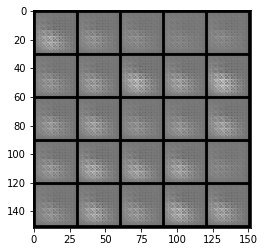

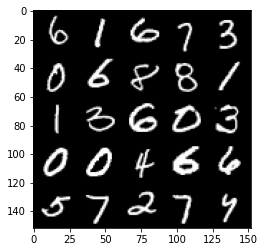

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2, step 938: Generator loss: 2.0303786173304017, discriminator loss: 0.2509576505911886


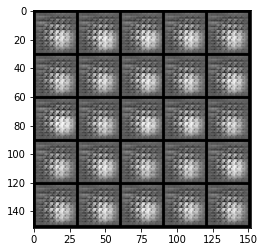

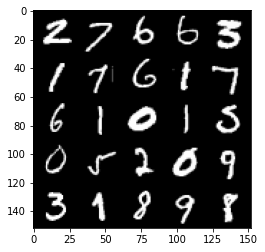

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3, step 1407: Generator loss: 2.235709934139938, discriminator loss: 0.24962867424686327


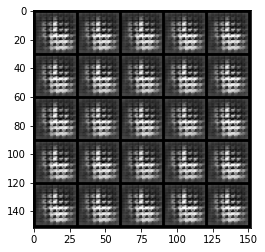

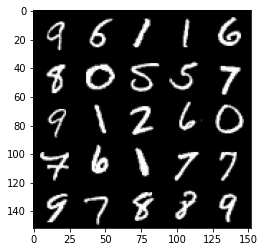

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4, step 1876: Generator loss: 1.8896978938503306, discriminator loss: 0.31660670942779784


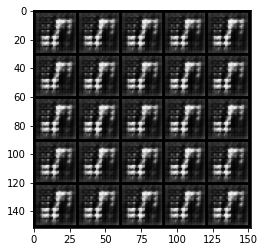

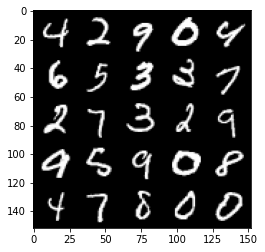

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5, step 2345: Generator loss: 1.8316341253486028, discriminator loss: 0.3469736992931572


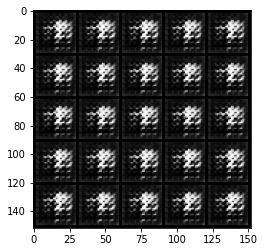

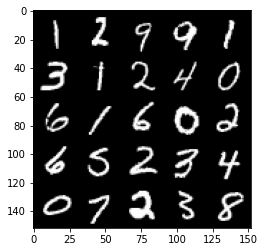

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6, step 2814: Generator loss: 1.7567128726541346, discriminator loss: 0.3560573495209602


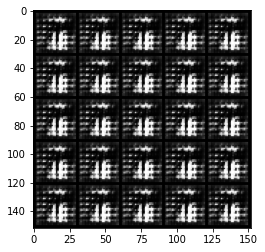

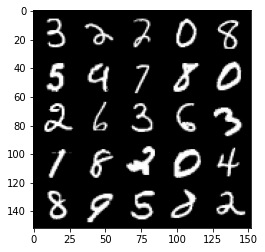

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7, step 3283: Generator loss: 1.5825618008401845, discriminator loss: 0.4324220721083665


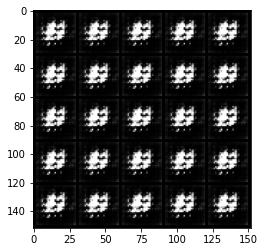

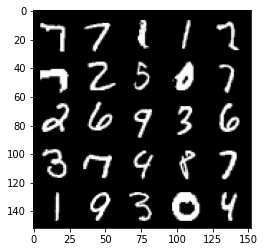

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8, step 3752: Generator loss: 1.8021755744653478, discriminator loss: 0.3531792853146729


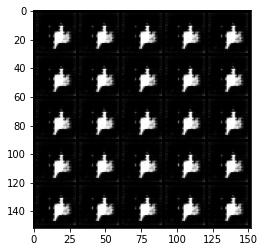

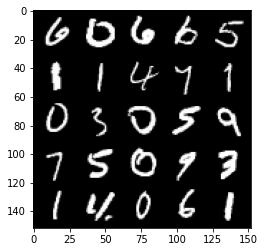

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9, step 4221: Generator loss: 1.702294674700002, discriminator loss: 0.40475942292955686


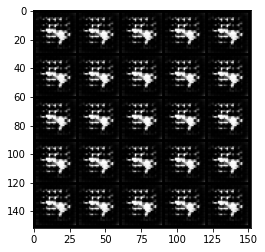

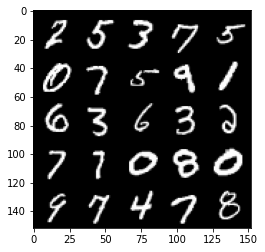

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10, step 4690: Generator loss: 1.6732604549383538, discriminator loss: 0.4077830216460134


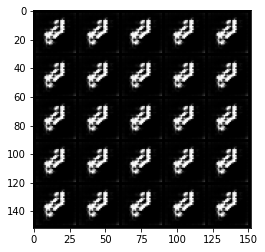

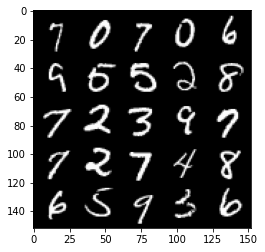

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 11, step 5159: Generator loss: 1.4534187767106586, discriminator loss: 0.4893544987956093


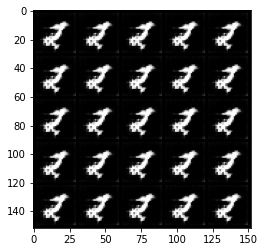

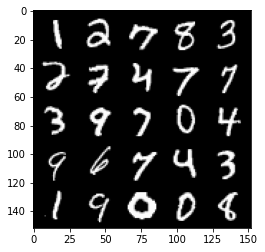

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 12, step 5628: Generator loss: 1.5562980816816736, discriminator loss: 0.4571381053372996


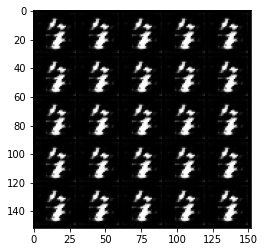

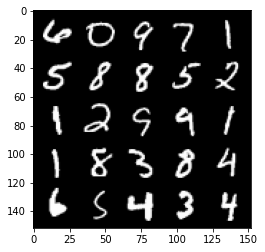

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 13, step 6097: Generator loss: 1.5575887577365957, discriminator loss: 0.43615248716716326


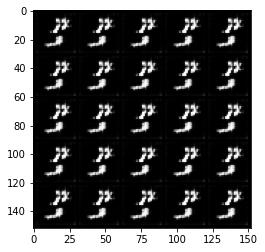

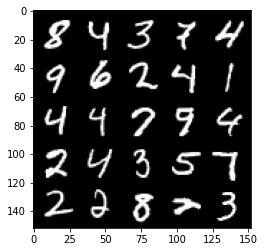

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 14, step 6566: Generator loss: 1.6603536684630007, discriminator loss: 0.4667502385593938


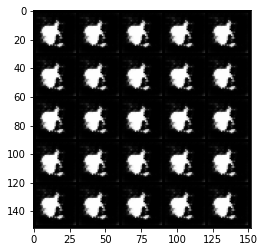

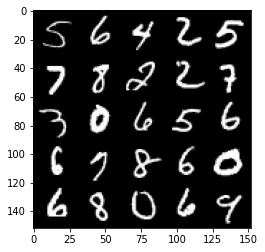

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 15, step 7035: Generator loss: 1.7217480107538237, discriminator loss: 0.38077984326111985


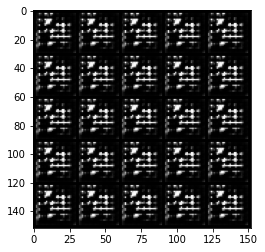

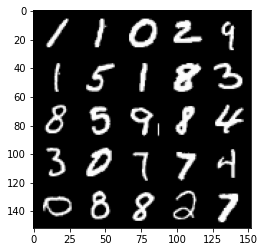

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 16, step 7504: Generator loss: 1.6805994049318318, discriminator loss: 0.4303761413261326


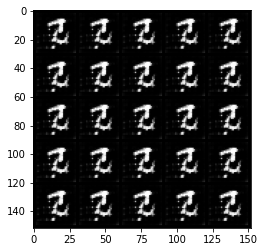

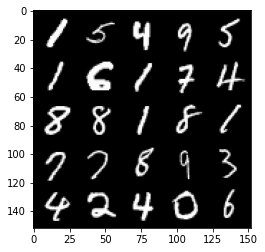

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 17, step 7973: Generator loss: 1.5604192093491316, discriminator loss: 0.4587975642892091


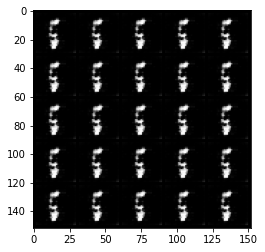

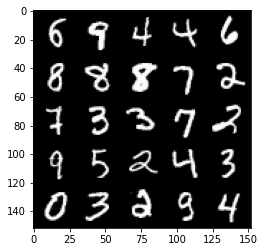

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 18, step 8442: Generator loss: 1.686436468985544, discriminator loss: 0.40342069372757144


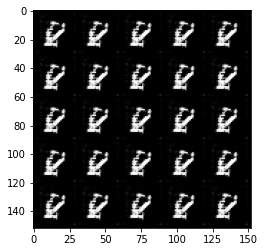

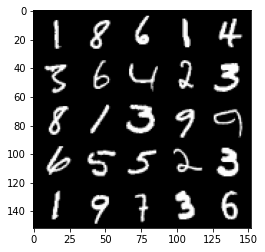

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 19, step 8911: Generator loss: 1.5148457049815112, discriminator loss: 0.4703886274780549


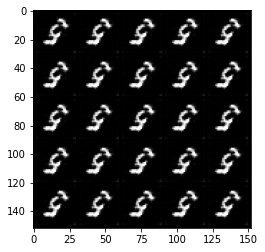

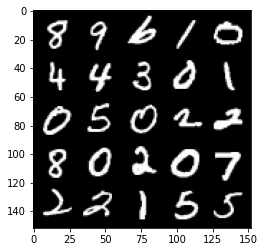

In [13]:
# OPTIONAL PART

cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
test_generator = True # Whether the generator should be tested
gen_loss = False
error = False
history = {}
history['Disc_loss'] = []
history['Gen_loss'] = []
real_images= []
fake_images = []
n_epochs = 20
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0

for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)
        history_disc_loss = []
        history_gen_loss = []
        ## Update discriminator ##
        disc_opt.zero_grad()
        disc_loss, fake = get_disc_loss(gen, disc, criterion, real, z_dim, device)
        history_disc_loss.append(disc_loss)
        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update optimizer
        disc_opt.step()

        ## Update generator ##
        gen_opt.zero_grad()
        
        gen_loss = get_gen_loss(gen, disc, criterion, z_dim, device)
        history_gen_loss.append(gen_loss)
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ## Visualization code ##
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            real_images.append(real)
            fake_images.append(fake)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1
    history['Disc_loss'].append(torch.mean(torch.FloatTensor(history_disc_loss)))
    history['Gen_loss'].append(torch.mean(torch.FloatTensor(history_gen_loss)))

## Plotting Losses

In [14]:
from matplotlib import pyplot as plt

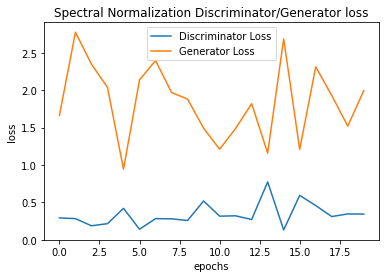

In [20]:
plt.plot(range(len(history['Disc_loss'])), history['Disc_loss'])
plt.plot(range(len(history['Gen_loss'])), history['Gen_loss'])
plt.title('Spectral Normalization Discriminator/Generator loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['Discriminator Loss', 'Generator Loss'])
plt.show()

Now we will save each epoch's image for more illustration.

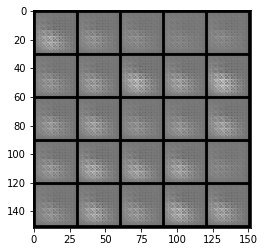

In [16]:
show_tensor_images(fake_images[0])

In [17]:
type(fake_images[0])

torch.Tensor

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

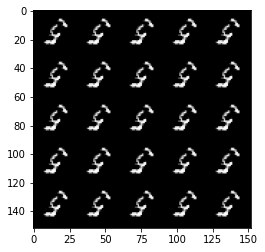

In [18]:
images = []
size=(1, 28, 28)
num_images=25
i = 1
for filename in fake_images:
  image_unflat = filename.detach().cpu().view(-1, *size)
  image_grid = make_grid(image_unflat[:num_images], nrow=5)
  image_grid = image_grid.permute(1, 2, 0).squeeze()
  image_grid = image_grid.detach().cpu().numpy()
  plt.imshow(image_grid)
  plt.imsave('output/'+str(i)+'.png', abs(image_grid))
  i+=1
  

In [19]:
!zip -r /content/filereal.zip /content/outputr
!zip -r /content/filefake.zip /content/output
from google.colab import files
files.download("/content/filereal.zip")
files.download("/content/filefake.zip")

updating: content/outputr/ (stored 0%)
updating: content/output/ (stored 0%)
updating: content/output/7.png (deflated 7%)
updating: content/output/15.png (deflated 7%)
updating: content/output/5.png (deflated 9%)
updating: content/output/12.png (deflated 6%)
updating: content/output/17.png (deflated 6%)
updating: content/output/13.png (deflated 7%)
updating: content/output/4.png (deflated 8%)
updating: content/output/8.png (deflated 5%)
updating: content/output/18.png (deflated 6%)
updating: content/output/2.png (deflated 9%)
updating: content/output/6.png (deflated 9%)
updating: content/output/16.png (deflated 6%)
updating: content/output/3.png (deflated 11%)
updating: content/output/9.png (deflated 7%)
updating: content/output/19.png (deflated 6%)
updating: content/output/1.png (deflated 5%)
updating: content/output/14.png (deflated 6%)
updating: content/output/11.png (deflated 6%)
updating: content/output/10.png (deflated 6%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>